<a href="https://colab.research.google.com/github/Crall-Lab/SICB2025_CV/blob/activity_testing/deepLearningNotebooks/1_training/SICB2025_objDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone the SICB Computer Vision Github
!git clone https://github.com/Crall-Lab/SICB2025_CV.git -b activity_testing

Cloning into 'SICB2025_CV'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 305 (delta 62), reused 14 (delta 14), pack-reused 177 (from 1)
Receiving objects: 100% (305/305), 167.62 MiB | 23.35 MiB/s, done.
Resolving deltas: 100% (138/138), done.


# Creating training folder

In [ ]:
#@title Unzip all files
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/trainIms0.zip
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/trainIms1.zip
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/trainIms2.zip
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/trainIms3.zip
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/trainIms4.zip
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/trainIms5.zip

!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/valIms1.zip
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/valIms2.zip


In [3]:
#@title Move images to a single folder
import glob
import os
import shutil

# For the training files
getFolds = glob.glob('/content/content/train_*/*')
for ele in getFolds:
  if os.path.isdir('/content/trainIms/'+ele.split('/')[-1]) == False:os.makedirs('/content/trainIms/'+ele.split('/')[-1])


getFiles = glob.glob('/content/content/train_*/*/*')
for ele in getFiles:
  tempFile = '/content/trainIms/'+ele.split('/')[-2]+'/'+ele.split('/')[-1]
  shutil.copyfile(ele,tempFile)



# for the validation files
getFolds = glob.glob('/content/content/valIm*/*')
for ele in getFolds:
  if os.path.isdir('/content/valIms/'+ele.split('/')[-1]) == False:os.makedirs('/content/valIms/'+ele.split('/')[-1])


getFiles = glob.glob('/content/content/valIm*/*/*')
for ele in getFiles:
  tempFile = '/content/valIms/'+ele.split('/')[-2]+'/'+ele.split('/')[-1]
  shutil.copyfile(ele,tempFile)

!rm /content/content/ -r

# Read in annotations

In [4]:
#@title Load annotations
import pickle
in1 = open('/content/SICB2025_CV/deepLearningNotebooks/1_training/annotations','rb')
annotations = pickle.load(in1)

# dictionary of training set bounding boxes
trainBbx = annotations[0]

# dictionary of validation set bounding boxes:
valBbx = annotations[1]

in1.close()

In [5]:
# get all image directory paths and put into a list
imageDirs = glob.glob('/content/trainIms/*/*')

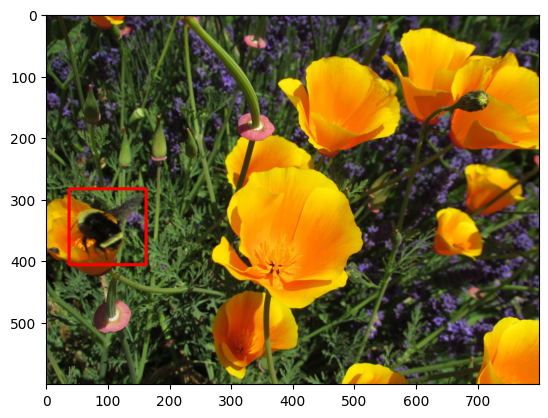

In [6]:
#@title display random image with bbx
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np

plt.figure()

# grab random image
randInt = int(np.random.rand()*len(imageDirs))
randImPath = imageDirs[randInt]

# grab the genus and species
ele = randImPath.split('/')[-2]

# read the image
in1 = cv.imread(randImPath)[:,:,::-1].astype(np.uint8)
sz1 = in1.shape

# load annotations
bbxs = trainBbx[randImPath]
for bbx in bbxs:

  xCnt = bbx[0]
  yCnt = bbx[1]
  width = bbx[2]
  height = bbx[3]

  x1 = xCnt-(width/2)
  x2 = xCnt+(width/2)
  y1 = yCnt-(height/2)
  y2 = yCnt+(height/2)

  v1 = (int(x1*sz1[1]),int(y1*sz1[0]))
  v2 = (int(x2*sz1[1]),int(y2*sz1[0]))
  c1 = (255,0,0)
  th = 3
  cv.rectangle(in1,v1,v2,c1,th)

plt.imshow(in1)



In [49]:
# annotations are:
# x-center, y-center, width, height

# yolo annotation
#class, x1, y1, width, height

# Yolo Object detection model training

In [7]:
# Creating the yolo training format

if os.path.isdir('/content/images/train/') is False:os.makedirs('/content/images/train/')
if os.path.isdir('/content/labels/train/') is False:os.makedirs('/content/labels/train/')

for ele in trainBbx:
  in1 = open('/content/labels/train/'+ele.split('/')[-1].split('.')[0]+'.txt','w')
  for ann in trainBbx[ele]:
    tLine= '0 %s %s %s %s\n'%(ann[0],ann[1],ann[2],ann[3])
    in1.write(tLine)
  in1.close()
  shutil.copyfile(ele,'/content/images/train/'+ele.split('/')[-1])

In [8]:
# Creating the yolo validation format

if os.path.isdir('/content/images/val/') is False:os.makedirs('/content/images/val/')
if os.path.isdir('/content/labels/val/') is False:os.makedirs('/content/labels/val/')


for ele in valBbx:
  if os.path.isfile('/content/labels/val/'+ele.split('/')[-1].split('.')[0]+'.txt') is True:
    in1 = open('/content/labels/val/'+ele.split('/')[-1].split('.')[0]+'.txt','a')
  else:
    in1 = open('/content/labels/val/'+ele.split('/')[-1].split('.')[0]+'.txt','w')
  for ann in valBbx[ele]:
    tLine= '0 %s %s %s %s\n'%(ann[0],ann[1],ann[2],ann[3])
    in1.write(tLine)
  in1.close()
  shutil.copyfile(ele,'/content/images/val/'+ele.split('/')[-1])

In [9]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.3/112.6 GB disk)


In [ ]:
# Validate YOLO11n on COCO8 val
#!yolo val model=yolo11n.pt data=coco8.yaml

In [ ]:
#@title Select YOLO11 🚀 logger {run: 'auto'}
logger = 'TensorBoard' #@param ['Comet', 'TensorBoard']

if logger == 'Comet':
  %pip install -q comet_ml
  import comet_ml; comet_ml.init()
elif logger == 'TensorBoard':
  %load_ext tensorboard
  %tensorboard --logdir .

In [ ]:
from ultralytics import YOLO

# Load a model
#model = YOLO('yolo11n.yaml')  # build a new model from scratch
model = YOLO('yolo11n.pt')  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data='/content/SICB2025_CV/deepLearningNotebooks/1_training/sicb.yaml', epochs=15)  # train the model
#results = model.val()  # evaluate model performance on the validation set
#results = model('https://ultralytics.com/images/bus.jpg')  # predict on an image
#results = model.export(format='onnx')  # export the model to ONNX format

In [ ]:
results = model.export(format='tflite')  # export the model to tflite format

In [ ]:
#!pip install -U jax jaxlib

In [15]:
model = YOLO('/content/runs/detect/train/weights/best.pt')

In [28]:
resultz = model('/content/sample_bee_crop.jpg')


image 1/1 /content/sample_bee_crop.jpg: 512x640 1 insect, 65.6ms
Speed: 14.0ms preprocess, 65.6ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)


In [27]:
resultz = model('/content/sample_bee.jpg')


image 1/1 /content/sample_bee.jpg: 480x640 (no detections), 16.8ms
Speed: 4.7ms preprocess, 16.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
resultz[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([])
conf: tensor([])
data: tensor([], size=(0, 6))
id: None
is_track: False
orig_shape: (1944, 2592)
shape: torch.Size([0, 6])
xywh: tensor([], size=(0, 4))
xywhn: tensor([], size=(0, 4))
xyxy: tensor([], size=(0, 4))
xyxyn: tensor([], size=(0, 4))

In [24]:
# Mount the Google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [32]:
shutil.copytree('/content/runs/detect/train2/','/content/drive/MyDrive/SICB_YOLO_15epochs/')

'/content/drive/MyDrive/SICB_YOLO_15epochs/'